<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [3]:
import os
import torch
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['xtick.major.width'] = 3 
plt.rcParams['ytick.major.width'] = 3


from itertools import combinations
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Periodically-underdamped oscillator:  <br>
Paper: Harmonic Oscillators with Nonlinear Damping
$$
\begin{aligned}
\dot{x} & = y \\
\dot{y} & = -ax + b y\hspace{1.5mm}\text{cos}(cx) \\
\end{aligned}
$$

Parameters: \\(a\\), \\(b\\), \\(c\\), \\(d\\)

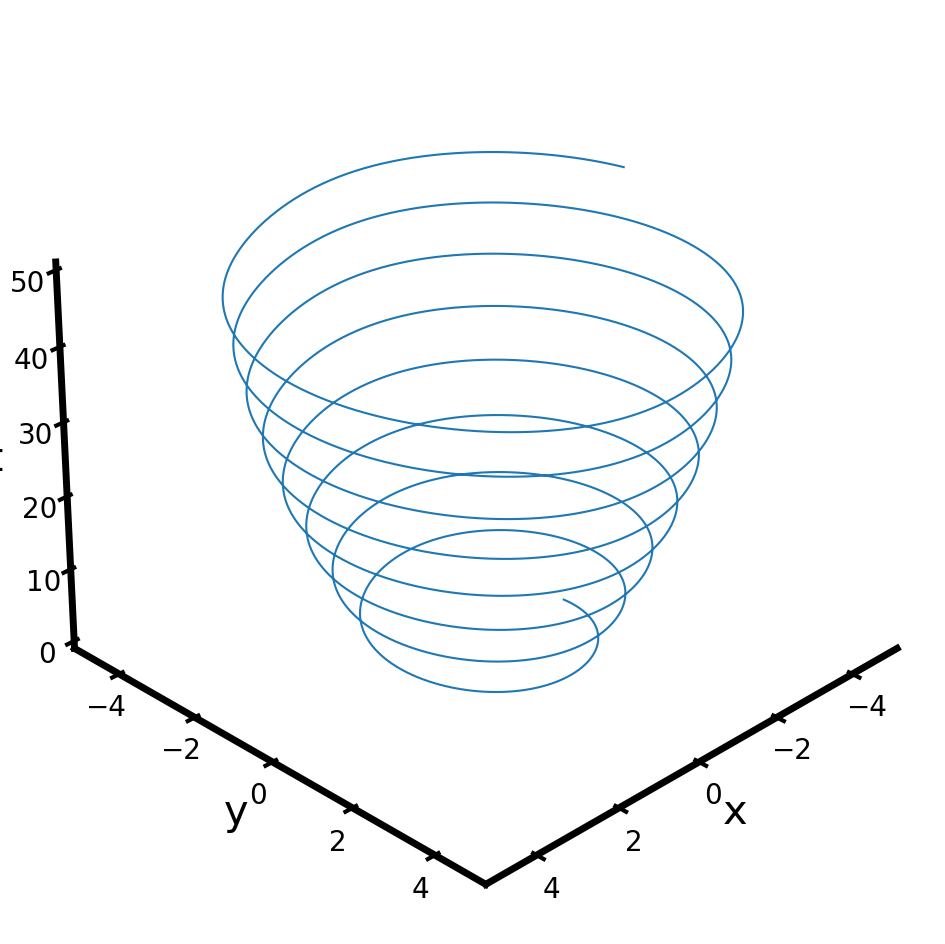

In [5]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)
a = -1.0
b =  0.1
c =  0.750

def oscillator_deriv(x_y, t0, a = a, b = b, c = c):
    x, y = x_y
    return [y, a*x +(b*y)*(np.cos(c*x))]

np.random.seed(123)
x0 = (-2, 0)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plotting the data
ax.plot(x[t<=50], y[t<=50], t[t<=50])

# Setting labels with Times New Roman font
ax.set_xlabel("x", labelpad=8, fontsize = 30)
ax.set_ylabel("y", labelpad=8, fontsize = 30)
ax.set_zlabel("t", labelpad=8, fontsize = 30)

# Set limits for x and y axes
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('3d_plot.pdf', format='pdf', bbox_inches='tight')

# Display plot
plt.show()


<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\youne\AppData\Local\Temp\ipykernel_8092\494232966.py:12: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set(ylabel="$\dot{x}$")
C:\Users\youne\AppData\Local\Temp\ipykernel_8092\494232966.py:16: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set(xlabel="t", ylabel="$\dot{y}$")


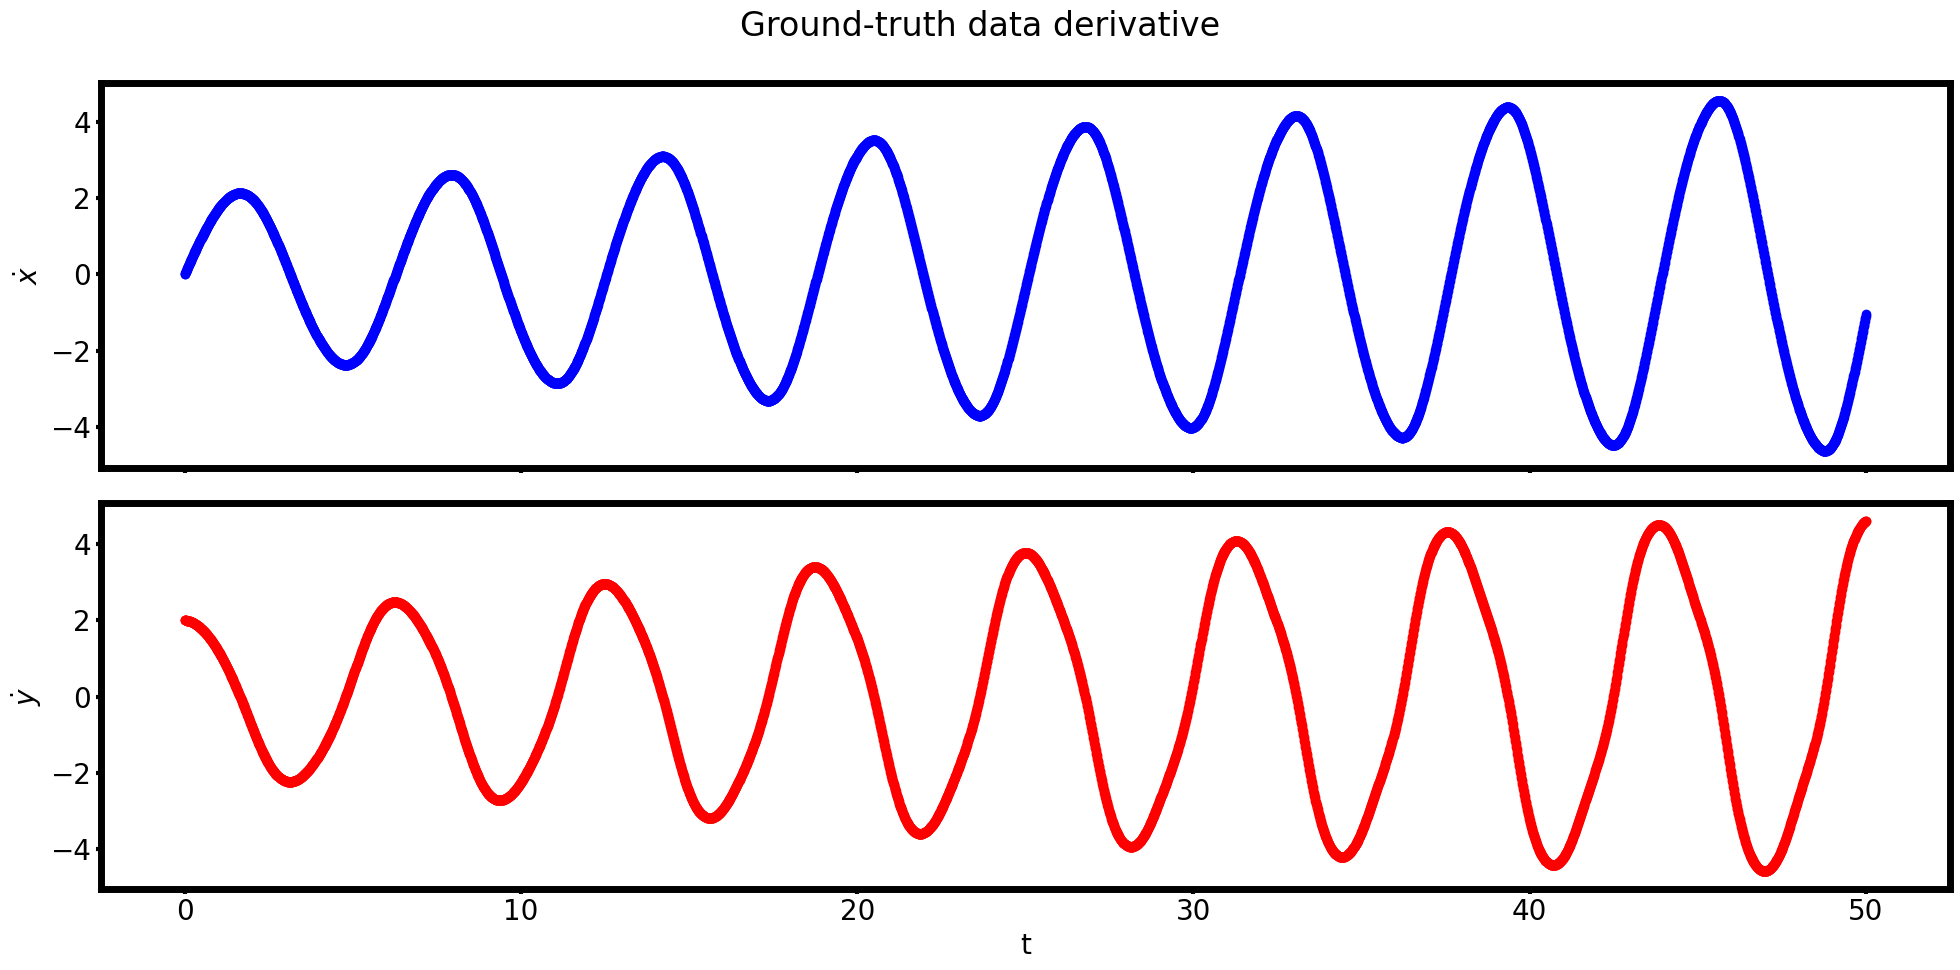

In [6]:
def DERIVATIVE(x, y, a, b, c):
    dxdt = y
    dydt = a*x + b*y*np.cos(c*x)    
    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE (x, y, a, b, c)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t, A1A2_time_deriv[:, 0], '-o', color='blue')
ax[0].set(ylabel="$\dot{x}$")
ax[0].set_xticklabels([])

ax[1].plot(t, A1A2_time_deriv[:, 1], '-o', color='red')
ax[1].set(xlabel="t", ylabel="$\dot{y}$")

fig.tight_layout()
plt.show()

In [7]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout


def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [8]:
sin_freq = [0.2,0.5,0.7,1.0]         # frequencies for sin and cos function

x_exp_powers = [ 1.0]                # coefficients for exponential of x [exp(a*x)] 
y_exp_powers = [ 1.0]                # coefficents for exponential of y [exp(a*y)]

def generate_candidates(x_t, sin_freq, x_exp_powers, y_exp_powers):
    """
    Generates polynomial, sine, cosine, and exponential terms, and their combinations
    based on input data. Handles cases where x_t has dimensions (1000, 2) or (1, 2).
    
    Parameters:
    x_t : array-like of shape (N, 2)
        Input data for N data points with two variables (x and y).
    sin_freq : list of float
        Frequencies for sine and cosine functions.
    x_exp_powers : list of float
        Coefficients for the exponential of x (exp(a*x)).
    y_exp_powers : list of float
        Coefficients for the exponential of y (exp(a*y)).
    
    Returns:
    All_candidates : array-like
        Combined matrix of polynomial, sine, cosine, and exponential terms.
    """
    
    # Extract x and y from x_t
    x = x_t[:, 0]  # First column is x
    y = x_t[:, 1]  # Second column is y
    
    # Polynomial terms (modify poolData if needed to handle both shapes)
    polynomial = poolData(x_t, 2, 1)
    poly_candidate = polynomial[:, 1:]
    
    N_sin_freq = len(sin_freq)
    
    # Fourier terms
    Nsize = poly_candidate.shape[1] * N_sin_freq
    sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    cos_candidate = np.zeros((poly_candidate.shape[0], Nsize))
    
    k = 0
    for i in range(poly_candidate.shape[1]):
        for j in range(N_sin_freq):
            sine_candidate[:, k] = np.sin(poly_candidate[:, i] * sin_freq[j])
            cos_candidate[:, k] = np.cos(poly_candidate[:, i] * sin_freq[j])
            k += 1
    
    # Fourier terms * polynomial terms
    xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    xcos_candidate = np.zeros((poly_candidate.shape[0], Nsize * poly_candidate.shape[1]))
    
    k = 0
    for i in range(Nsize):
        for j in range(poly_candidate.shape[1]):
            xsine_candidate[:, k] = sine_candidate[:, i] * poly_candidate[:, j]
            xcos_candidate[:, k] = cos_candidate[:, i] * poly_candidate[:, j]
            k += 1
    
    # Exponential terms
    x_exp_powered = np.array([np.exp(x * p) for p in x_exp_powers]).T  # Shape (N, len(x_exp_powers))
    y_exp_powered = np.array([np.exp(y * p) for p in y_exp_powers]).T  # Shape (N, len(y_exp_powers))
    
    # Combine x and y exponential terms
    all_exp = np.hstack([x_exp_powered, y_exp_powered])
    
    # Polynomial * exponential terms
    x_exp_combination = np.concatenate([poly_candidate * x_exp[:, None] for x_exp in x_exp_powered.T], axis=1)
    y_exp_combination = np.concatenate([poly_candidate * y_exp[:, None] for y_exp in y_exp_powered.T], axis=1)
    
    # Combine all exponential terms
    all_exp_combinations = np.hstack([all_exp, x_exp_combination, y_exp_combination])
    
    # Combine all candidate terms
    All_candidates = np.hstack((polynomial, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate, all_exp_combinations))
    
    return All_candidates

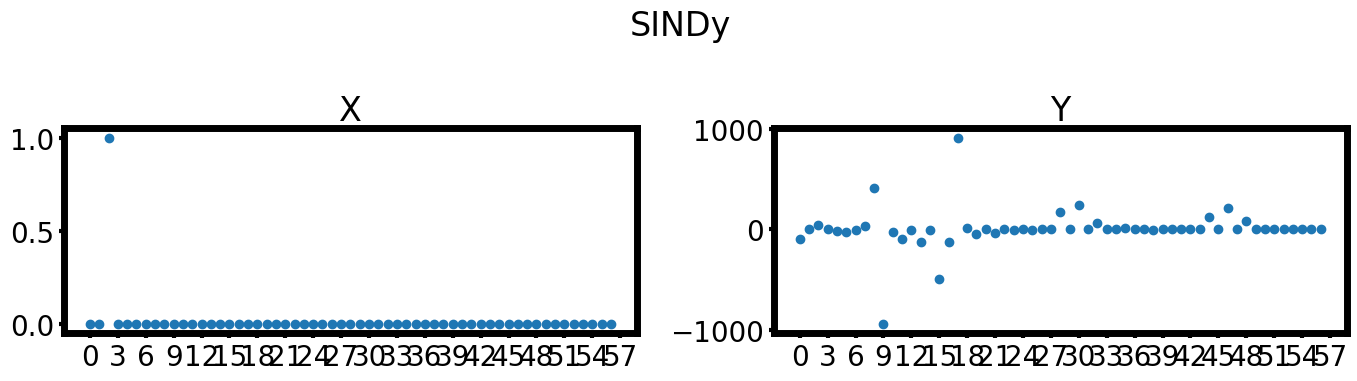

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -95.66283647135013     0.554007381110476   48.23299713180984
    2.313018987540769  -13.773095055168602  -28.53423483839669
   -0.101270315442375   30.531037498688217  416.8784629964791
 -940.6773473016572    -25.249273302876293  -93.38863802423353
   -3.303002856164262 -120.88203776772617    -2.524794373924325
 -493.7326429024474   -119.75477288068605   914.5569290314987
   14.71426099933074   -47.80714164798721     0.
  -33.70802604881008     0.                  -9.421721765069032
    0.                  -0.148498361761718    0.
    0.                 172.65046803869137     0.
  246.64871328168041     0.                  68.48206069917369
    0.                   0.798912062829224   13.35279864005167
    0.245857408602577    9.79372930252888    -0.13979389239985
    1.798641282592496    0.165984924730525    0.

In [9]:
Candidates = generate_candidates (x_t, sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers)

lamb = 0.01 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(Candidates, A1A2_time_deriv, lamb, 2)
#print(coeff_matrix)
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o')
ax[0].set_title('X')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(coeff_matrix [:, 1], 'o')
ax[1].set_title('Y')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[:, 0])
print(coeff_matrix[:, 1])

In [10]:
def SINDy_oscillator_deriv(x_y, t):
    out = generate_candidates (np.array(x_y)[np.newaxis, :], sin_freq=sin_freq, x_exp_powers=x_exp_powers, y_exp_powers=y_exp_powers)@coeff_matrix
    return np.squeeze(out).tolist()

np.random.seed(123)
x0 = (-2, 0)
x1_t = integrate.odeint(SINDy_oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x1, y1 = x1_t.T

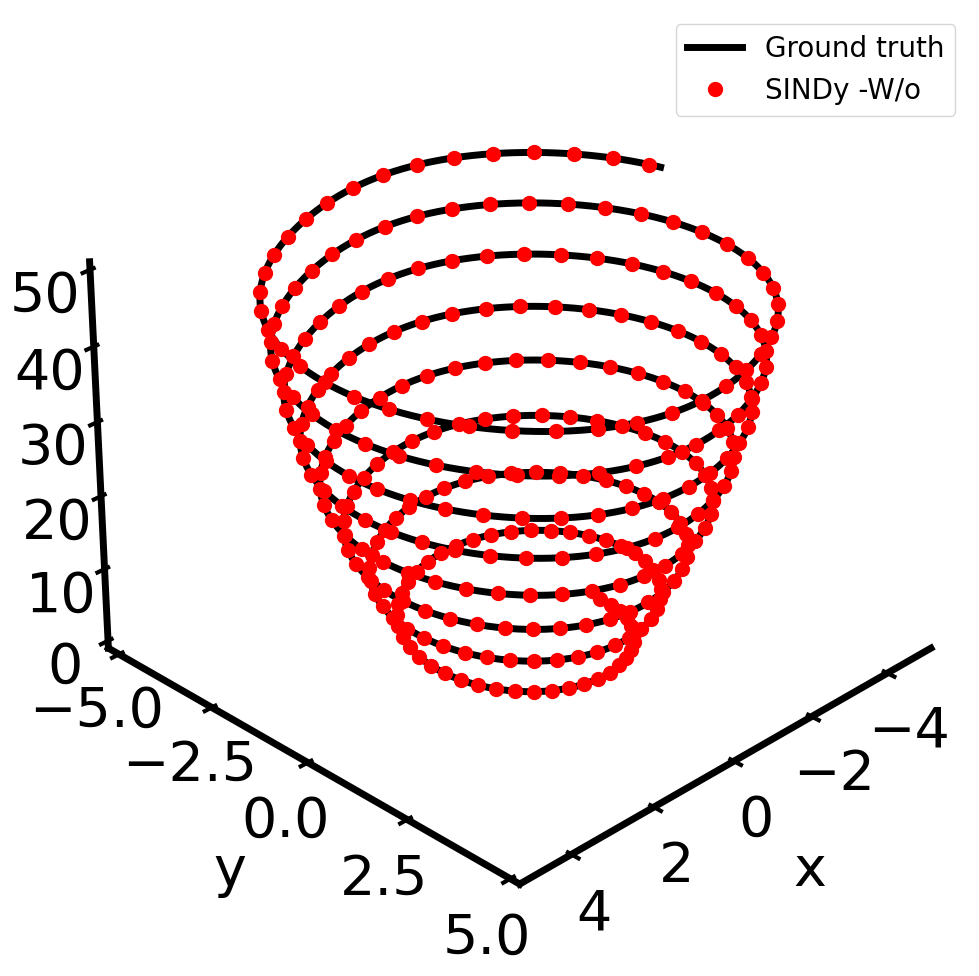

In [11]:
# Create figure and 3D plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


# Plotting the data
ax.plot(x[t<=50],  y[t<=50], t[t<=50], label="Ground truth", linewidth=5, color ='black')
ax.plot(x1[t<=50], y1[t<=50], t[t<=50], label="SINDy -W/o", linewidth=0, marker=".", markersize=20, markevery=15, color='red')
ax.legend(fontsize=20)

# Setting labels with Times New Roman font
ax.set_xlabel("x", labelpad=40, fontsize = 40)
ax.set_ylabel("y", labelpad=40, fontsize = 40)
ax.set_zlabel("t", labelpad=40, fontsize = 40)

# Set limits for x and y axes
#ax.set_xlim(-5, 5)
#ax.set_ylim(-5, 5)

# Remove background pane and borders
ax.xaxis.pane.fill = False  # Remove background pane for x-axis
ax.yaxis.pane.fill = False  # Remove background pane for y-axis
ax.zaxis.pane.fill = False  # Remove background pane for z-axis

# Turn off the pane borders
ax.xaxis.pane.set_edgecolor('none')  # No border for x-axis pane
ax.yaxis.pane.set_edgecolor('none')  # No border for y-axis pane
ax.zaxis.pane.set_edgecolor('none')  # No border for z-axis pane

# Remove grid
ax.grid(False)


# Adjust tick parameters to increase the font size of axis tick labels
ax.tick_params(axis='x', labelsize=40, pad=10)  # Increase font size of x-axis tick labels
ax.tick_params(axis='y', labelsize=40, pad=10)  # Increase font size of y-axis tick labels
ax.tick_params(axis='z', labelsize=40, pad=10)  # Increase font size of z-axis tick labels

ax.view_init(30, 45, 0)
# Save figure to a PDF file
plt.savefig('Comparison.jpeg', dpi = 1200)
plt.savefig('Comparison.pdf', dpi = 1200)

# Display plot
plt.show()

In [12]:
print(np.linalg.norm(x1_t - x_t, ord=2) / x.size)

7.267071760424462e-08


In [13]:
non_zero_x = np.count_nonzero(coeff_matrix[:, 0])
non_zero_y = np.count_nonzero(coeff_matrix[:, 1])

print("Number of non-zero values for x:", non_zero_x)
print("Number of non-zero values for y:", non_zero_y)

Number of non-zero values for x: 1
Number of non-zero values for y: 38
